In [1]:
import numpy as np
import pandas as pd
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
warnings.filterwarnings('ignore')

In this competition your task is to predict whether a passenger was transported to an alternate dimension during the Spaceship Titanic's collision with the spacetime anomaly. To help you make these predictions, you're given a set of personal records recovered from the ship's damaged computer system.

# File and Data Field Descriptions
* train.csv - Personal records for about two-thirds (~8700) of the passengers, to be used as training data.
* PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
* HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
* CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
* Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
* Destination - The planet the passenger will be debarking to.
* Age - The age of the passenger.
* VIP - Whether the passenger has paid for special VIP service during the voyage.
* RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
* Name - The first and last names of the passenger.
* Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

In [2]:
train = pd.read_csv('../input/spaceship-titanic/train.csv')
test = pd.read_csv('../input/spaceship-titanic/test.csv')
sub = pd.read_csv('../input/spaceship-titanic/sample_submission.csv')
print(train.shape)
print(test.shape)

(8693, 14)
(4277, 13)


In [3]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


# EDA

In [4]:
def eda(df):
    summary = pd.DataFrame()
    summary['dtypes'] = df.dtypes
    summary['missing'] = df.isnull().sum()
    summary['nlevel'] = df.nunique()
    return summary

eda(train)

,dtypes,missing,nlevel
PassengerId,object,0,8693
HomePlanet,object,201,3
CryoSleep,object,217,2
Cabin,object,199,6560
Destination,object,182,3
Age,float64,179,80
VIP,object,203,2
RoomService,float64,181,1273
FoodCourt,float64,183,1507
ShoppingMall,float64,208,1115


In [5]:
eda(test)

,dtypes,missing,nlevel
PassengerId,object,0,4277
HomePlanet,object,87,3
CryoSleep,object,93,2
Cabin,object,100,3265
Destination,object,92,3
Age,float64,91,79
VIP,object,93,2
RoomService,float64,82,842
FoodCourt,float64,106,902
ShoppingMall,float64,98,715


In [6]:
train.duplicated().sum()

0

## Target

In [7]:
train['Transported'].value_counts()

True     4378
False    4315
Name: Transported, dtype: int64

In [8]:
train.select_dtypes(include = 'object').columns


train['HomePlanet'].value_counts()

Earth     4602
Europa    2131
Mars      1759
Name: HomePlanet, dtype: int64

In [9]:
train['CryoSleep'].value_counts()

False    5439
True     3037
Name: CryoSleep, dtype: int64

In [10]:
train['Destination'].value_counts()

TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
Name: Destination, dtype: int64

In [11]:
train['VIP'].value_counts()

False    8291
True      199
Name: VIP, dtype: int64

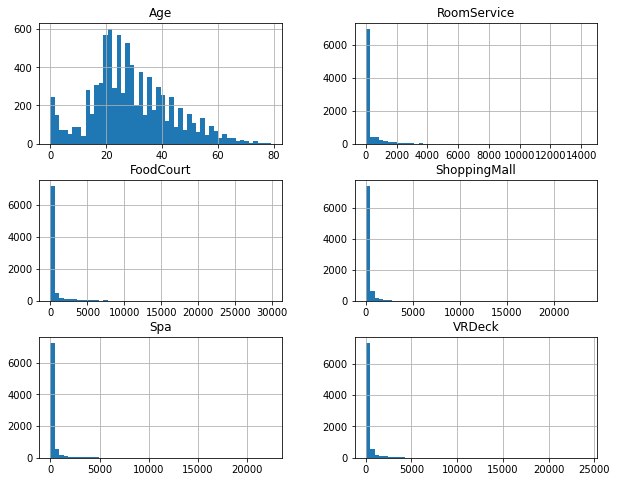

In [12]:
train.hist(bins = 50, figsize = (10,8))
plt.show()

In [13]:
train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [14]:
#train[train.Spa > 10000]

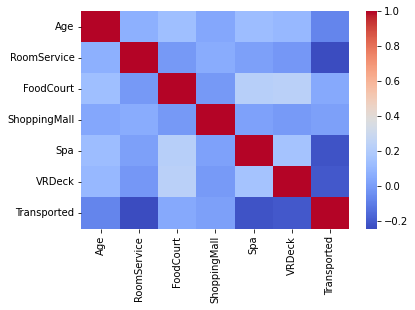

In [15]:
sns.heatmap(train.corr(), cmap = 'coolwarm')
plt.show()

In [16]:
train.corr()['Transported'].sort_values().reset_index()

,index,Transported
0,RoomService,-0.244611
1,Spa,-0.221131
2,VRDeck,-0.207075
3,Age,-0.075026
4,ShoppingMall,0.010141
5,FoodCourt,0.046566
6,Transported,1.000000


# FE

In [17]:
df = pd.concat([train, test])

df['Transported'] = df['Transported'].fillna(-1).astype('int')
df['CryoSleep'] = df['CryoSleep'].fillna(-1).astype('int')
df['VIP'] = df['VIP'].fillna(-1).astype('int')

obj_cols = ['HomePlanet',   'Destination', 'Name','Cabin']
for c in obj_cols:
    df[c] = df[c].fillna('None')

num_cols = ['Age','RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
for c in num_cols:
    df[c] = df[c].fillna(df[c].median())
    
  
print(df.shape)

(12970, 14)


In [18]:
df['deck'] = df['Cabin'].astype(str).apply(lambda x: x.split('/')[0])
df['num'] = df['Cabin'].astype(str).apply(lambda x: int(x.split('/')[1]) if x != 'None' else -1)
df['side'] = df['Cabin'].astype(str).apply(lambda x: x.split('/')[-1])

#df['total_spent'] = df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis = 1)
#df['Age'] = pd.cut(df['Age'], 8)

df['deck_side'] = df['deck'].astype(str) + '_' + df['side'].astype(str)
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,deck,num,side,deck_side
0,0001_01,Europa,0,B/0/P,TRAPPIST-1e,39.0,0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0,B,0,P,B_P
1,0002_01,Earth,0,F/0/S,TRAPPIST-1e,24.0,0,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1,F,0,S,F_S
2,0003_01,Europa,0,A/0/S,TRAPPIST-1e,58.0,1,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0,A,0,S,A_S
3,0003_02,Europa,0,A/0/S,TRAPPIST-1e,33.0,0,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,0,A,0,S,A_S
4,0004_01,Earth,0,F/1/S,TRAPPIST-1e,16.0,0,303.0,70.0,151.0,565.0,2.0,Willy Santantines,1,F,1,S,F_S


# Pre-processing

In [19]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
le = LabelEncoder()

for c in ['deck','side','Destination','HomePlanet','Age', 'deck_side']:
    df[c] = le.fit_transform(df[c])

df.head()    

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,deck,num,side,deck_side
0,0001_01,1,0,B/0/P,3,39,0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0,1,0,1,2
1,0002_01,0,0,F/0/S,3,24,0,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1,5,0,2,11
2,0003_01,1,0,A/0/S,3,58,1,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0,0,0,2,1
3,0003_02,1,0,A/0/S,3,33,0,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,0,0,0,2,1
4,0004_01,0,0,F/1/S,3,16,0,303.0,70.0,151.0,565.0,2.0,Willy Santantines,1,5,1,2,11


In [20]:
train[train.Age < 1]['Transported'].value_counts()

True     144
False     34
Name: Transported, dtype: int64

In [21]:
train = df[:len(train)]
test = df[-len(test):]

X_train = train.drop(['PassengerId','Cabin','Name','Transported'], axis = 1)
y_train = train.Transported

X_test = test.drop(['PassengerId','Cabin','Name','Transported'], axis = 1)

print(X_train.shape)
print(X_test.shape)

(8693, 14)
(4277, 14)


In [22]:
X_train.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,deck,num,side,deck_side
0,1,0,3,39,0,0.0,0.0,0.0,0.0,0.0,1,0,1,2
1,0,0,3,24,0,109.0,9.0,25.0,549.0,44.0,5,0,2,11
2,1,0,3,58,1,43.0,3576.0,0.0,6715.0,49.0,0,0,2,1
3,1,0,3,33,0,0.0,1283.0,371.0,3329.0,193.0,0,0,2,1
4,0,0,3,16,0,303.0,70.0,151.0,565.0,2.0,5,1,2,11


# LGBM

In [23]:
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import accuracy_score

oof = np.zeros(len(train))
preds = np.zeros(len(test))

skf = StratifiedKFold(n_splits = 6)

for i, (idt, idv) in enumerate(skf.split(X_train, y_train, y_train)):
    
    x_trn, x_val = X_train.iloc[idt], X_train.iloc[idv]
    y_trn, y_val = y_train.iloc[idt], y_train.iloc[idv]
    
    print('fold ', i+1)
    print('*' * 40)
    
    clf = lgb.LGBMClassifier(
    n_estimators = 1500,
        subsample = 0.8,
        #num_leaves = 32,
        learning_rate = 0.01,
        colsample_bytree = 0.8,
        reg_alpha = 1,
     
       # bagging_frequency = 1,
        #random_state = 42
       
        
    )
    
    clf.fit(x_trn, y_trn, eval_set = [(x_trn, y_trn),(x_val, y_val)], verbose = 100,
           early_stopping_rounds=100, eval_metric = 'auc',
           #categorical_feature = ['VIP','deck','side','Destination','HomePlanet']
           )
    
    oof[idv] = clf.predict(x_val)
    preds += clf.predict_proba(X_test)[:,1]/skf.n_splits

print('OOF accuracy', accuracy_score(y_train, oof))

fold  1
****************************************
[100]	training's auc: 0.911099	training's binary_logloss: 0.468582	valid_1's auc: 0.879857	valid_1's binary_logloss: 0.49531
[200]	training's auc: 0.920438	training's binary_logloss: 0.397264	valid_1's auc: 0.883315	valid_1's binary_logloss: 0.440758
[300]	training's auc: 0.929108	training's binary_logloss: 0.361461	valid_1's auc: 0.885907	valid_1's binary_logloss: 0.424485
[400]	training's auc: 0.936343	training's binary_logloss: 0.339343	valid_1's auc: 0.888583	valid_1's binary_logloss: 0.41586
[500]	training's auc: 0.942469	training's binary_logloss: 0.323393	valid_1's auc: 0.890327	valid_1's binary_logloss: 0.41147
[600]	training's auc: 0.947344	training's binary_logloss: 0.310865	valid_1's auc: 0.890283	valid_1's binary_logloss: 0.409772
fold  2
****************************************
[100]	training's auc: 0.914022	training's binary_logloss: 0.46539	valid_1's auc: 0.845161	valid_1's binary_logloss: 0.522837
fold  3
****************

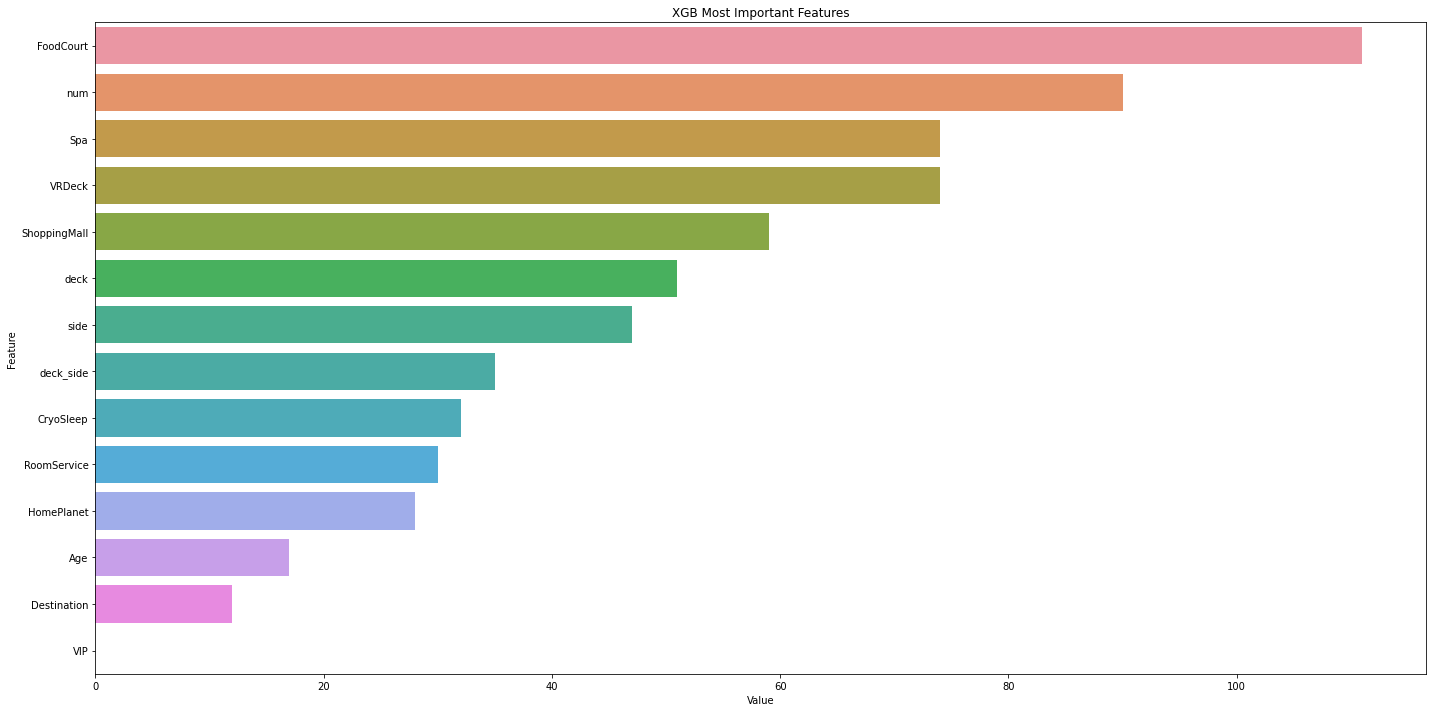

In [24]:
cols = list(X_train.columns)
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_,cols)), columns=['Value','Feature'])
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).iloc[:20])
plt.title('XGB Most Important Features')
plt.tight_layout()
plt.show()

In [25]:
preds

array([0.55345825, 0.19038603, 0.83275474, ..., 0.81378273, 0.67435636,
       0.56673207])

In [26]:
sub['Transported'] = [True if x>0.5 else False for x in preds]

sub

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True


In [27]:
sub['Transported'].describe()

count     4277
unique       2
top       True
freq      2269
Name: Transported, dtype: object

In [28]:
sub.to_csv('sub_lgb.csv', index = False)